# Demo — Unsupervised Learning: Clustering, Dimensionality Reduction, Autoencoders

**Course:** Applied Machine Learning   
**Topic:** Unsupervised Learning (Clustering + Dimensionality Reduction + Representation Learning)  
**Last updated:** 2026-02-24

This notebook complements the lecture deck *Unsupervised Learning* (K-means, PCA/SVD, hierarchical clustering, DBSCAN, and autoencoders).  
It is deliberately **visual and comparative**: we will apply several algorithms to the *same datasets*, compare behavior and metrics, and animate how iterative methods converge.

> **Key message**  
> In unsupervised learning we typically want one of two things:
> 1) **Grouping** (discover structure: clusters)  
> 2) **Representation** (discover structure: low-dimensional manifold / latent space)

---

## Contents

1. Setup  
2. Datasets (why geometry matters)  
3. K-means: objective, failure modes, and animations  
4. Choosing $K$: elbow vs silhouette  
5. Hierarchical clustering: dendrogram + geometry intuition  
6. DBSCAN: density connectivity + parameter sensitivity  
7. Side-by-side comparison on multiple datasets  
8. PCA via SVD: intuition + reconstructions  
9. Autoencoders: linear vs nonlinear + anomaly detection demo  
10. Takeaways

In [1]:
# ===== Setup =====
import numpy as np
import matplotlib.pyplot as plt

from dataclasses import dataclass

from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA

import time

# Optional (for dendrogram)
from scipy.cluster.hierarchy import linkage, dendrogram

np.random.seed(42)
plt.rcParams["figure.dpi"] = 120

def timer(fn, *args, **kwargs):
    t0 = time.perf_counter()
    out = fn(*args, **kwargs)
    t1 = time.perf_counter()
    return out, (t1 - t0)

def standardize(X):
    return StandardScaler().fit_transform(X)

def scatter_2d(X, labels=None, title="", ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 4))
    if labels is None:
        ax.scatter(X[:, 0], X[:, 1], s=18, alpha=0.8)
    else:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=18, alpha=0.85)
    ax.set_title(title)
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.grid(True, alpha=0.25)
    return ax

## 2) Datasets: why geometry matters

Unsupervised methods implicitly assume geometry:

- **K-means** assumes roughly *spherical* clusters (Voronoi partitions) and optimizes within-cluster SSE.  
- **Hierarchical** depends on how we define *cluster-to-cluster distance* (linkage).  
- **DBSCAN** assumes clusters are *dense regions* separated by low density.

We'll create a few synthetic datasets that highlight these assumptions.

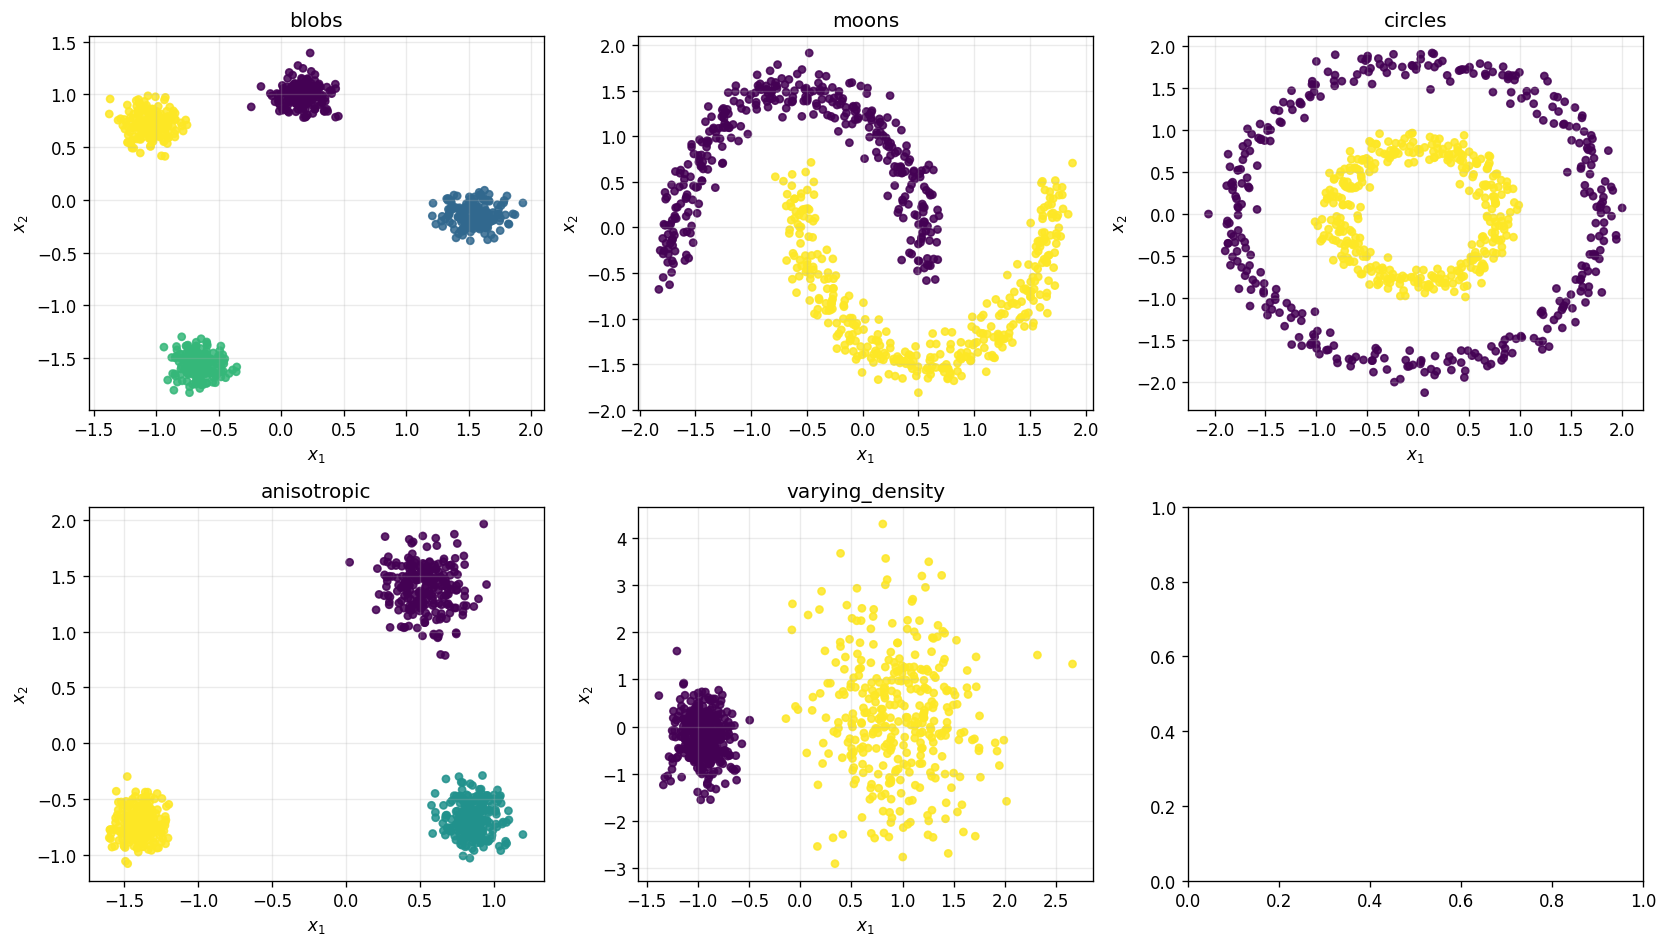

In [2]:
# ===== Datasets =====
def make_datasets(n=600):
    datasets = {}

    # 1) Easy: well-separated blobs
    X, y = make_blobs(n_samples=n, centers=4, cluster_std=0.65, random_state=42)
    datasets["blobs"] = (standardize(X), y)

    # 2) Non-convex: moons (K-means will struggle)
    X, y = make_moons(n_samples=n, noise=0.07, random_state=42)
    datasets["moons"] = (standardize(X), y)

    # 3) Non-convex: circles
    X, y = make_circles(n_samples=n, factor=0.45, noise=0.05, random_state=42)
    datasets["circles"] = (standardize(X), y)

    # 4) Anisotropic blobs (elliptical clusters)
    X, y = make_blobs(n_samples=n, centers=3, cluster_std=[1.0, 0.7, 0.6], random_state=42)
    A = np.array([[0.6, -0.6],
                  [0.4,  0.8]])
    X = X @ A
    datasets["anisotropic"] = (standardize(X), y)

    # 5) Varying density (DBSCAN is sensitive)
    X1, y1 = make_blobs(n_samples=n//2, centers=[(-2.2, -0.2)], cluster_std=0.35, random_state=1)
    X2, y2 = make_blobs(n_samples=n//2, centers=[( 2.2,  0.2)], cluster_std=0.95, random_state=2)
    X = np.vstack([X1, X2])
    y = np.hstack([y1*0, y2*0 + 1])
    datasets["varying_density"] = (standardize(X), y)

    return datasets

datasets = make_datasets(n=700)

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.ravel()
for ax, (name, (X, y)) in zip(axes, datasets.items()):
    scatter_2d(X, y, title=name, ax=ax)
plt.tight_layout()
plt.show()

## 3) K-means

### Objective

Given assignments $A(i)\in\{1,\dots,K\}$ and centroids $c_k$, K-means minimizes:

$$
J = \frac{1}{m}\sum_{i=1}^m \|x^{(i)} - c_{A(i)}\|^2
$$

Algorithm:
1. Initialize centroids  
2. **Assign** each point to its closest centroid  
3. **Update** each centroid as the mean of assigned points  
4. Repeat until assignments stop changing (or iterations limit)

This is an **iterative** method → perfect for animation.

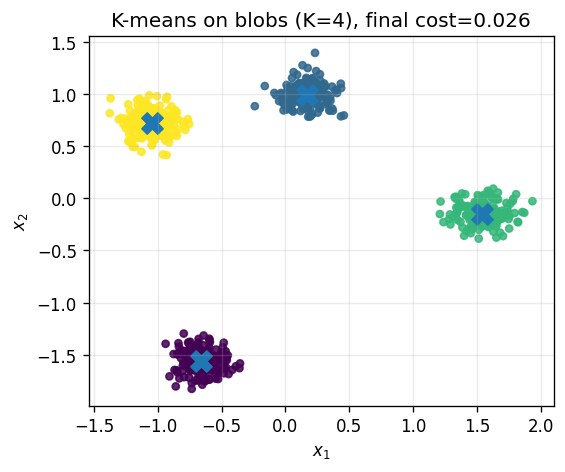

In [3]:
# K-means trajectory with detailed frames (init, assign, update)

def kmeans_trajectory_detailed(X, K, init="k-means++", max_iter=15, random_state=42):
    rng = np.random.RandomState(random_state)

    # ---- initialize centroids ----
    if init == "random":
        idx = rng.choice(len(X), size=K, replace=False)
        C = X[idx].copy()
    elif init == "k-means++":
        km0 = KMeans(n_clusters=K, init="k-means++", n_init=1, max_iter=1, random_state=random_state)
        km0.fit(X)
        C = km0.cluster_centers_.copy()
    else:
        raise ValueError("init must be 'random' or 'k-means++'")

    traj = []
    labels0 = -1 * np.ones(len(X), dtype=int)  # unassigned yet
    traj.append(("init", C.copy(), labels0, np.nan))

    for it in range(max_iter):
        # ---- ASSIGN ----
        d2 = ((X[:, None, :] - C[None, :, :]) ** 2).sum(axis=2)
        labels = d2.argmin(axis=1)
        J = float(np.mean(np.min(d2, axis=1)))
        traj.append((f"assign {it+1}", C.copy(), labels.copy(), J))

        # ---- UPDATE ----
        C_new = np.vstack([
            X[labels == k].mean(axis=0) if np.any(labels == k) else C[k]
            for k in range(K)
        ])
        d2_new = ((X[:, None, :] - C_new[None, :, :]) ** 2).sum(axis=2)
        J_new = float(np.mean(np.min(d2_new, axis=1)))
        traj.append((f"update {it+1}", C_new.copy(), labels.copy(), J_new))

        if np.allclose(C_new, C):
            break
        C = C_new

    return traj

X, _ = datasets["blobs"]
traj = kmeans_trajectory_detailed(X, K=4, init="k-means++", max_iter=12, random_state=0)
phase, C, labels, J = traj[-1]

fig, ax = plt.subplots(figsize=(5, 4))
scatter_2d(X, labels, title=f"K-means on blobs (K=4), final cost={J:.3f}", ax=ax)
ax.scatter(C[:, 0], C[:, 1], s=160, marker="X")
plt.show()

### Animation: K-means convergence (assign → update)

Below we animate:
- centroids moving
- labels changing
- cost decreasing

This is the easiest way for students to understand that K-means is *coordinate descent* on $A(i)$ and $c_k$ (alternating optimization).

In [4]:
# Animation: show assign/update steps explicitly
import matplotlib.animation as animation
from IPython.display import HTML

def animate_kmeans_detailed(X, K, init="k-means++", max_iter=15, random_state=0, interval=650):
    traj = kmeans_trajectory_detailed(X, K=K, init=init, max_iter=max_iter, random_state=random_state)

    fig, ax = plt.subplots(figsize=(5.8, 4.8))
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.grid(True, alpha=0.25)

    scat = ax.scatter(X[:, 0], X[:, 1], s=18, alpha=0.85)
    cent = ax.scatter([], [], s=220, marker="X")

    xmin, xmax = X[:,0].min()-0.4, X[:,0].max()+0.4
    ymin, ymax = X[:,1].min()-0.4, X[:,1].max()+0.4
    ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)

    title = ax.text(0.02, 1.02, "", transform=ax.transAxes)

    def colorize(labels):
        if np.all(labels == -1):
            return np.zeros(len(labels), dtype=float)
        return labels.astype(float)

    def init_anim():
        phase, C, labels, J = traj[0]
        scat.set_array(colorize(labels))
        cent.set_offsets(C)
        title.set_text("K-means — initialization (centroids placed)")
        return scat, cent, title

    def update(frame):
        phase, C, labels, J = traj[frame]
        scat.set_array(colorize(labels))
        cent.set_offsets(C)

        if np.isnan(J):
            msg = f"K-means — {phase}: centroids placed (no assignments yet)"
        else:
            if phase.startswith("assign"):
                msg = f"K-means — {phase}: recompute labels (nearest centroid), J={J:.4f}"
            else:
                msg = f"K-means — {phase}: move centroids to cluster means, J={J:.4f}"
        title.set_text(msg)
        return scat, cent, title

    ani = animation.FuncAnimation(
        fig, update, frames=len(traj), init_func=init_anim,
        interval=interval, blit=True, repeat=False
    )
    plt.close(fig)
    return ani

X, _ = datasets["blobs"]
init_ = "random"
ani = animate_kmeans_detailed(X, K=4, init=init_, max_iter=20, random_state=6, interval=650)
HTML(ani.to_jshtml())

**Interpretation (moons dataset):**  
Even though the *true* structure is two curved clusters, K-means will still build a **linear Voronoi partition**. It can converge, but to a solution that does not match the geometry.

That is not a bug: it is a consequence of the objective.

## 4) Choosing $K$: elbow vs silhouette

### Elbow (heuristic)
Plot cost $J(K)$ vs $K$ and look for a knee.

### Silhouette (more principled)
For each sample $i$:
- $a(i)$ = average distance from $i$ to points in its **own** cluster  
- $b(i)$ = minimum (over other clusters) of the average distance from $i$ to that **other** cluster

Silhouette for sample $i$:
$$
s(i)=\frac{b(i)-a(i)}{\max(a(i),b(i))}
$$

Interpretation:
- $s \approx 1$: well separated  
- $s \approx 0$: overlapping clusters  
- $s < 0$: likely mis-clustered

We will compare elbow and silhouette on the same dataset.

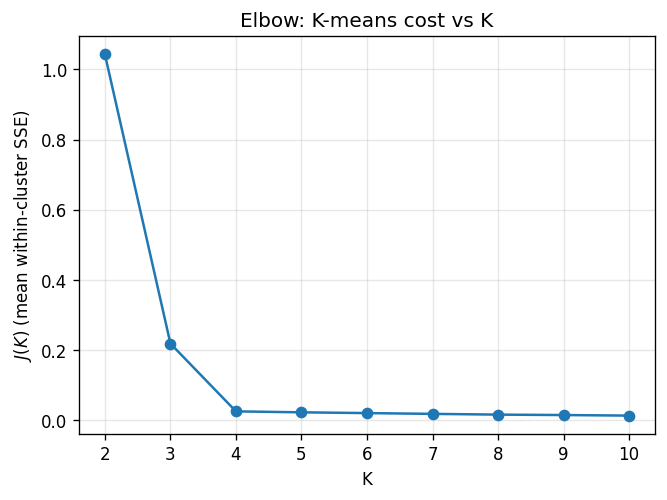

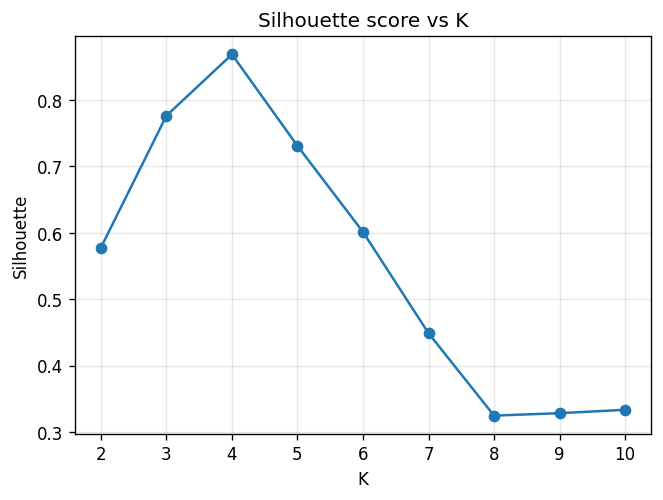

In [5]:
def elbow_and_silhouette(X, k_range=range(2, 11), random_state=0):
    Js = []
    sils = []
    for K in k_range:
        km = KMeans(n_clusters=K, init="k-means++", n_init=10, random_state=random_state)
        labels = km.fit_predict(X)
        Js.append(km.inertia_ / len(X))  # inertia is sum of squared distances
        sils.append(silhouette_score(X, labels))
    return np.array(list(k_range)), np.array(Js), np.array(sils)

X, _ = datasets["blobs"]
k, J, s = elbow_and_silhouette(X, range(2, 11))

fig, ax = plt.subplots(figsize=(6.2, 4.3))
ax.plot(k, J, marker="o")
ax.set_title("Elbow: K-means cost vs K")
ax.set_xlabel("K")
ax.set_ylabel(r"$J(K)$ (mean within-cluster SSE)")
ax.grid(True, alpha=0.3)
plt.show()

fig, ax = plt.subplots(figsize=(6.2, 4.3))
ax.plot(k, s, marker="o")
ax.set_title("Silhouette score vs K")
ax.set_xlabel("K")
ax.set_ylabel("Silhouette")
ax.grid(True, alpha=0.3)
plt.show()

## 5) Hierarchical Clustering (Agglomerative)

### Core Idea

Agglomerative hierarchical clustering works **bottom-up**:

- Start with each data point as its own cluster  
- Iteratively merge the two *closest clusters*  
- Continue until all points belong to a single cluster  

The result is represented as a **dendrogram** (a tree structure).

---

### 1) Distance Metric (Point-to-Point Distance)

Before defining cluster distances, we must define how we measure distance between two points.

Common distance metrics:

- **Euclidean distance**
  
  $$
  d(x_i, x_j) = \sqrt{\sum_k (x_{ik} - x_{jk})^2}
  $$

- **Manhattan distance (L1 distance)**
  
  $$
  d(x_i, x_j) = \sum_k |x_{ik} - x_{jk}|
  $$

- **Cosine distance**
  
  $$
  d(x_i, x_j) = 1 - \frac{x_i \cdot x_j}{\|x_i\|\|x_j\|}
  $$

This metric defines the geometry of the space.

---

### 2) Linkage Criterion (Cluster-to-Cluster Distance)

After defining point distance, we must define how to measure distance between **clusters**.

Let clusters be $A$ and $B$.

- **Single linkage** (Nearest-neighbor linkage)

  $$
  d(A,B) = \min_{x \in A, y \in B} d(x,y)
  $$

  → Sensitive to chaining effect

- **Complete linkage** (Farthest-neighbor linkage)

  $$
  d(A,B) = \max_{x \in A, y \in B} d(x,y)
  $$

  → Produces compact clusters

- **Average linkage**

  $$
  d(A,B) = \frac{1}{|A||B|} \sum_{x \in A}\sum_{y \in B} d(x,y)
  $$

  → Compromise between single and complete

- **Ward’s method**

  Minimizes the increase in within-cluster variance:

  $$
  \Delta(A,B) = \text{increase in } \sum ||x - \mu||^2
  $$

  → Tends to produce spherical clusters  
  → Requires Euclidean distance

---

### Strengths

- No need to choose $K$ beforehand  
- Dendrogram reveals hierarchical structure  
- Flexible distance definitions

---

### Limitations

- Greedy; merges cannot be undone  
- Computationally expensive for large $m$  
- Sensitive to distance metric choice  

---

### In this demo we will show:

1) A dendrogram (on a subset of data)  
2) Effect of different **linkage criteria**  
3) How geometry changes with different **distance metrics**

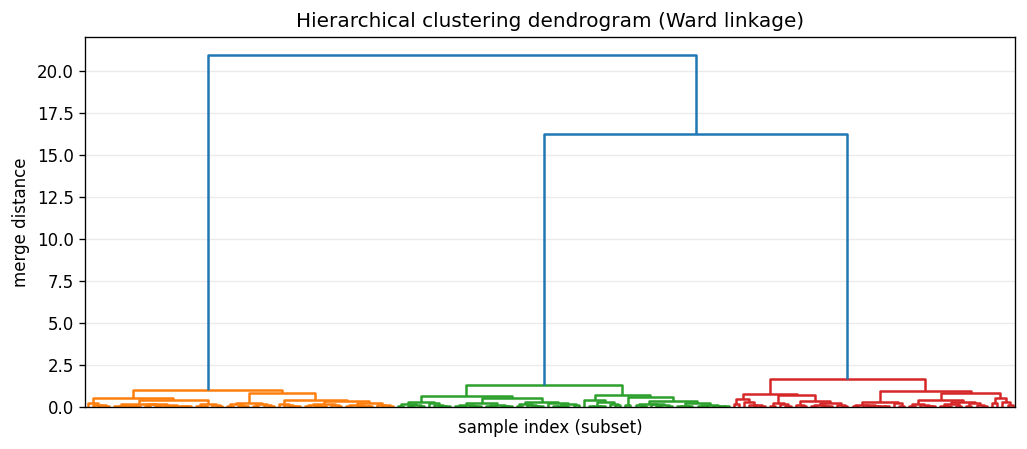

In [6]:
def plot_dendrogram(X, method="ward", sample=200, title=""):
    # dendrogram needs linkage matrix, which is O(n^2) memory -> use subset
    rng = np.random.RandomState(0)
    idx = rng.choice(len(X), size=min(sample, len(X)), replace=False)
    Xs = X[idx]
    Z = linkage(Xs, method=method)  # method in {'single','complete','average','ward'}
    plt.figure(figsize=(10, 4))
    dendrogram(Z, no_labels=True, color_threshold=None)
    plt.title(title or f"Dendrogram ({method} linkage), n={len(Xs)}")
    plt.xlabel("sample index (subset)")
    plt.ylabel("merge distance")
    plt.grid(True, axis="y", alpha=0.25)
    plt.show()

X, y_true = datasets["anisotropic"]
plot_dendrogram(X, method="ward", sample=180, title="Hierarchical clustering dendrogram (Ward linkage)")

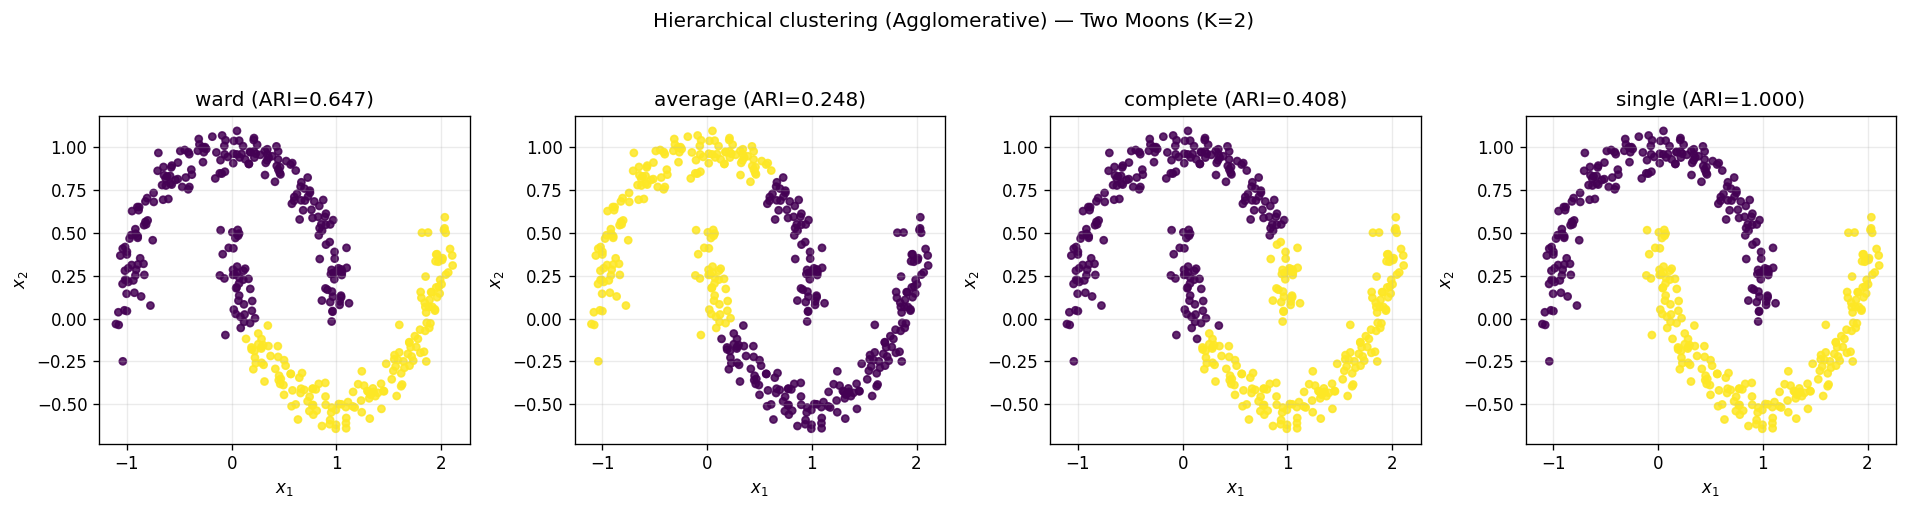

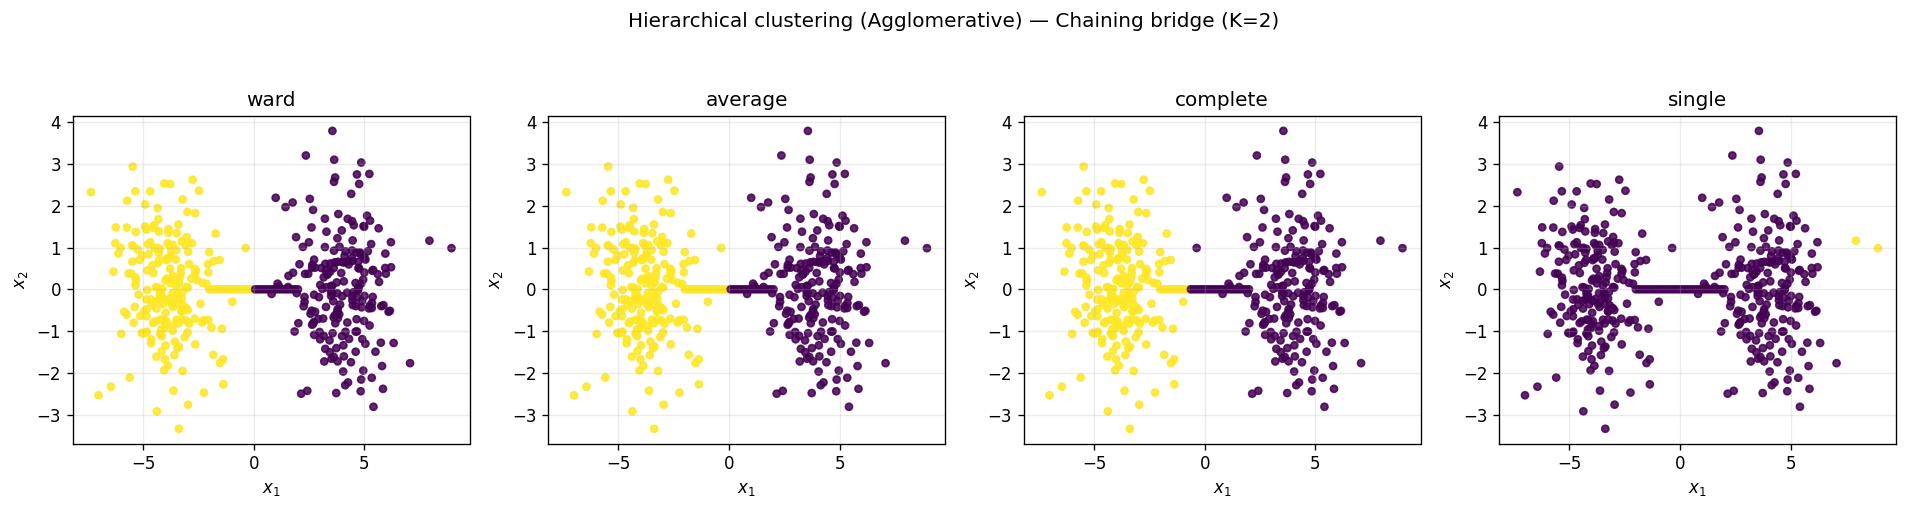

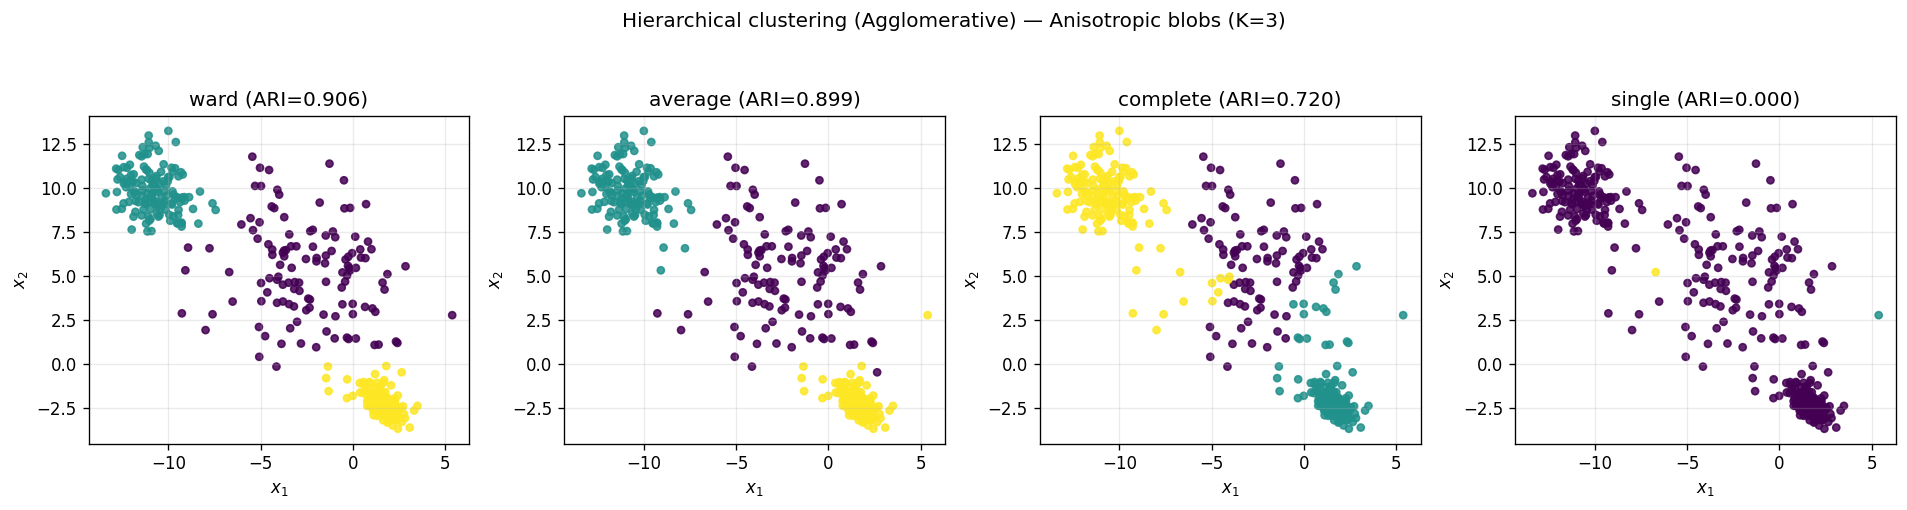

In [7]:
# Compare linkage effects visually by cutting the tree at K clusters (via sklearn)
def compare_agglomerative_linkage(X, y_true=None, K=3, dataset_name=""):
    linkages = [
        ("ward",     {"linkage": "ward"}),      # requires Euclidean
        ("average",  {"linkage": "average"}),
        ("complete", {"linkage": "complete"}),
        ("single",   {"linkage": "single"}),
    ]

    fig, axes = plt.subplots(1, len(linkages), figsize=(16, 4))
    fig.suptitle(f"Hierarchical clustering (Agglomerative) — {dataset_name}", y=1.05, fontsize=12)

    for ax, (name, kwargs) in zip(axes, linkages):
        model = AgglomerativeClustering(n_clusters=K, **kwargs)
        labels = model.fit_predict(X)

        if y_true is not None:
            ari = adjusted_rand_score(y_true, labels)
            title = f"{name} (ARI={ari:.3f})"
        else:
            title = name

        scatter_2d(X, labels, title=title, ax=ax)

    plt.tight_layout()
    plt.show()

# =========================
# 1) Two Moons (non-convex)
# =========================
X_moons, y_moons = make_moons(n_samples=400, noise=0.07, random_state=42)

# ===========================================
# 2) Chaining bridge (single linkage failure)
# ===========================================
X1, _ = make_blobs(n_samples=200, centers=[(-4, 0)], cluster_std=[1.2], random_state=1)
X2, _ = make_blobs(n_samples=200, centers=[(4, 0)],  cluster_std=[1.2], random_state=2)
bridge = np.linspace([-2, 0], [2, 0], 30)   # "bridge" points connecting the blobs
X_chain = np.vstack([X1, X2, bridge])
y_chain = None  # no meaningful "true labels" here

# ==================================
# 3) Strong anisotropic 3-blob setup
# ==================================
X_aniso, y_aniso = make_blobs(
    n_samples=400,
    centers=3,
    cluster_std=[1.0, 2.5, 0.5],
    random_state=170
)
transformation = np.array([[0.6, -1.2],
                           [1.0,  0.2]])
X_aniso = X_aniso @ transformation

# =========================
# Run all three comparisons
# =========================
compare_agglomerative_linkage(X_moons, y_true=y_moons, K=2, dataset_name="Two Moons (K=2)")
compare_agglomerative_linkage(X_chain, y_true=y_chain, K=2, dataset_name="Chaining bridge (K=2)")
compare_agglomerative_linkage(X_aniso, y_true=y_aniso, K=3, dataset_name="Anisotropic blobs (K=3)")

## 6) DBSCAN

DBSCAN forms clusters as **connected dense regions**.

Parameters:
- $\varepsilon$ (eps): neighborhood radius  
- `min_samples`: how many neighbors are needed to call a point a **core** point

Points:
- **core**: at least `min_samples` within $\varepsilon$  
- **border**: not core but within $\varepsilon$ of a core  
- **noise**: neither core nor density-reachable

This makes DBSCAN good at:
- arbitrary-shaped clusters  
- discovering outliers (noise points)

But it is sensitive to:
- feature scaling  
- choice of $\varepsilon$  
- datasets with varying density

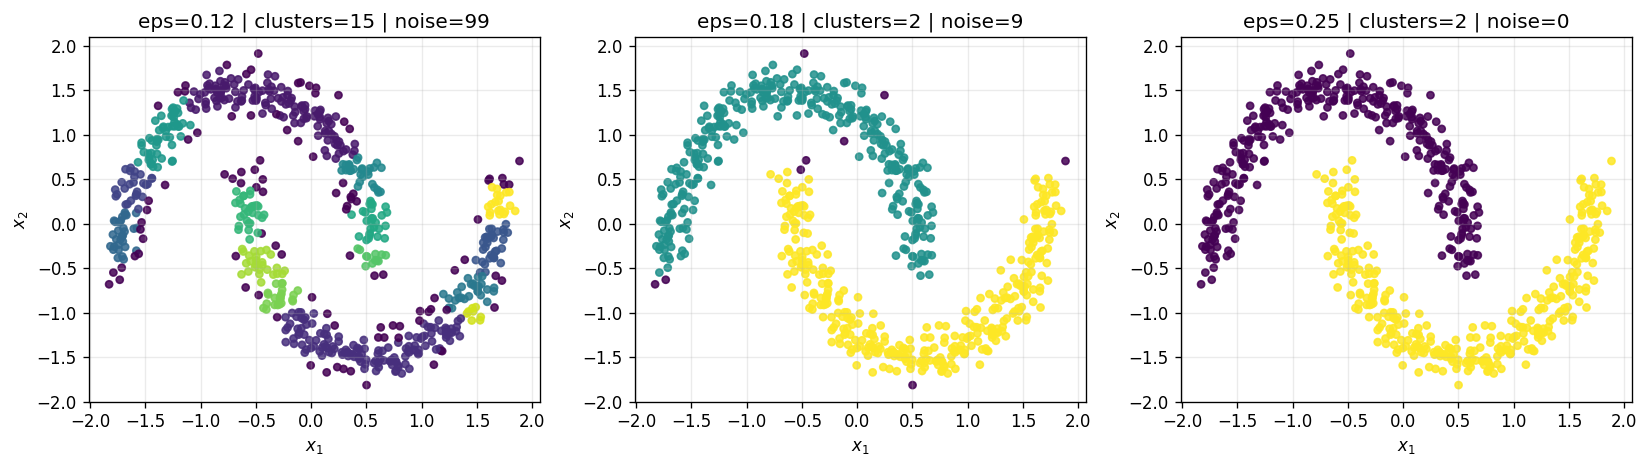

In [8]:
def run_dbscan_grid(X, eps_list, min_samples=8):
    fig, axes = plt.subplots(1, len(eps_list), figsize=(4.6*len(eps_list), 4))
    if len(eps_list) == 1:
        axes = [axes]
    for ax, eps in zip(axes, eps_list):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        labels = model.fit_predict(X)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = np.sum(labels == -1)
        scatter_2d(X, labels, title=f"eps={eps:.2f} | clusters={n_clusters} | noise={n_noise}", ax=ax)
    plt.tight_layout()
    plt.show()

X, _ = datasets["moons"]
run_dbscan_grid(X, eps_list=[0.12, 0.18, 0.25], min_samples=8)

### Animation: DBSCAN neighborhood growth intuition

DBSCAN is not typically explained as an *iterative optimizer*, but it is still an **iterative expansion** process:
- pick an unvisited point
- if it is core, it seeds a cluster
- expand the cluster by repeatedly adding density-reachable points

We animate the effect of changing $\varepsilon$ (eps) — effectively changing what "reachable" means.

In [9]:
from matplotlib.colors import ListedColormap, BoundaryNorm

def animate_dbscan_eps(X, eps_values, min_samples=8, interval=900):
    fig, ax = plt.subplots(figsize=(5.6, 4.6))
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.grid(True, alpha=0.25)

    xmin, xmax = X[:, 0].min() - 0.4, X[:, 0].max() + 0.4
    ymin, ymax = X[:, 1].min() - 0.4, X[:, 1].max() + 0.4
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # --- Precompute labels + stats ---
    labels_list = []
    stats = []
    max_label = -1
    for eps in eps_values:
        labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(X)
        labels_list.append(labels)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = int(np.sum(labels == -1))
        stats.append((n_clusters, n_noise))

        if labels.max() > max_label:
            max_label = labels.max()

    # --- Discrete colormap: 0..max_label are clusters, -1 is noise ---
    # We map values: -1 -> 0 (noise), 0 -> 1, 1 -> 2, ...
    # so we can use a clean discrete mapping.
    n_colors = (max_label + 1) + 1  # +1 for noise
    base = plt.cm.get_cmap("tab10", max(10, n_colors))
    colors = [ (0.6, 0.6, 0.6, 1.0) ] + [ base(i) for i in range(n_colors - 1) ]  # gray for noise
    cmap = ListedColormap(colors)

    # Boundaries for discrete bins: [-0.5, 0.5, 1.5, ...]
    # where 0=noise, 1=cluster0, 2=cluster1, ...
    boundaries = np.arange(-0.5, n_colors + 0.5, 1.0)
    norm = BoundaryNorm(boundaries, cmap.N)

    # Initial scatter (we'll update colors each frame)
    scat = ax.scatter(X[:, 0], X[:, 1], s=18, alpha=0.85, c=np.zeros(len(X)), cmap=cmap, norm=norm)
    title = ax.text(0.02, 1.02, "", transform=ax.transAxes)

    def to_color_index(labels):
        # -1 -> 0 (noise), k -> k+1 for clusters
        return np.where(labels == -1, 0, labels + 1)

    def init_anim():
        labels0 = labels_list[0]
        scat.set_array(to_color_index(labels0).astype(float))
        title.set_text("")
        return scat, title

    def update(frame):
        labels = labels_list[frame]
        n_clusters, n_noise = stats[frame]
        scat.set_array(to_color_index(labels).astype(float))
        title.set_text(f"DBSCAN — eps={eps_values[frame]:.3f} | clusters={n_clusters} | noise={n_noise}")
        return scat, title

    ani = animation.FuncAnimation(
        fig, update, frames=len(eps_values), init_func=init_anim,
        interval=interval, blit=True, repeat=False
    )
    plt.close(fig)
    return ani

# Example
X, _ = datasets["circles"]  # assumes you already have datasets dict
eps_values = np.linspace(0.08, 0.25, 10)

ani = animate_dbscan_eps(X, eps_values=eps_values, min_samples=10, interval=850)
HTML(ani.to_jshtml())

## 7) Side-by-side comparison on multiple datasets

We'll compare:
- K-means
- Agglomerative (Ward)
- DBSCAN

We will report:
- number of clusters found
- silhouette score (when defined)
- ARI (only because we have synthetic ground truth; in real data ARI is typically unavailable)

> **Note**: Silhouette is undefined for 1 cluster; also DBSCAN may label many points as noise (-1).  
In practice you interpret these metrics as *diagnostics*, not absolute truth.

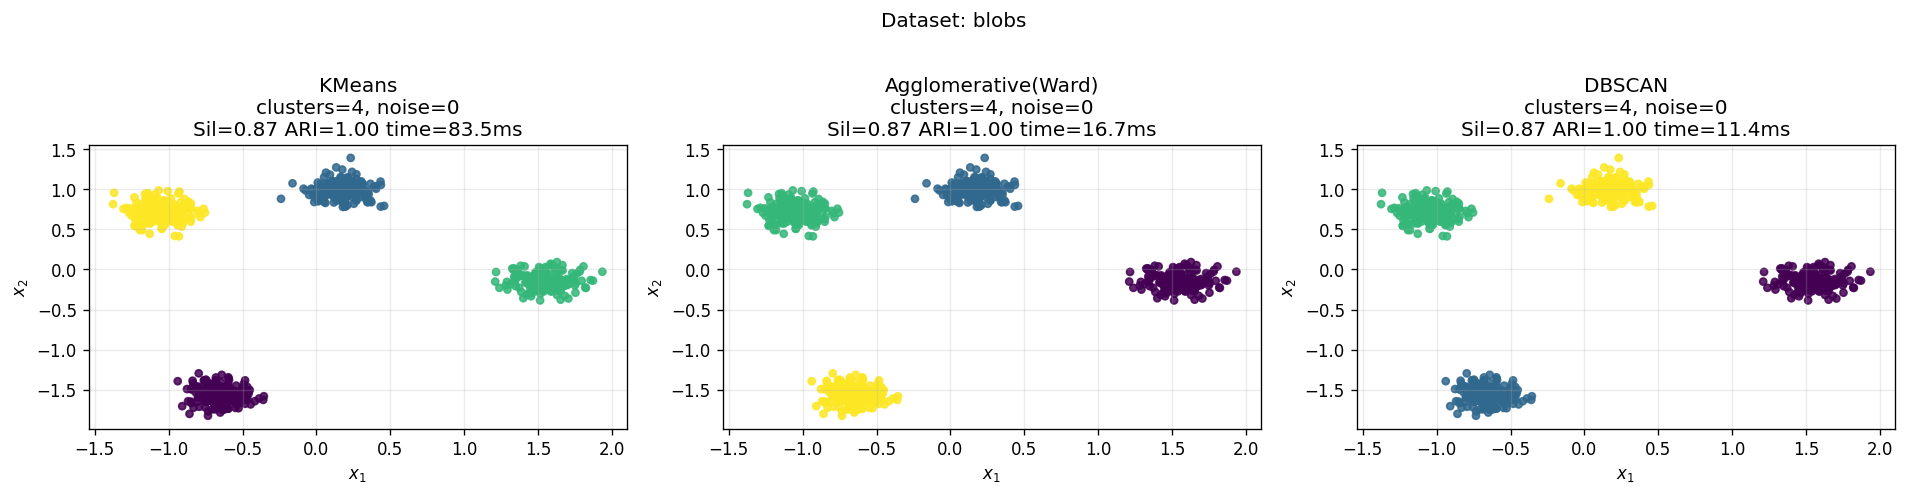

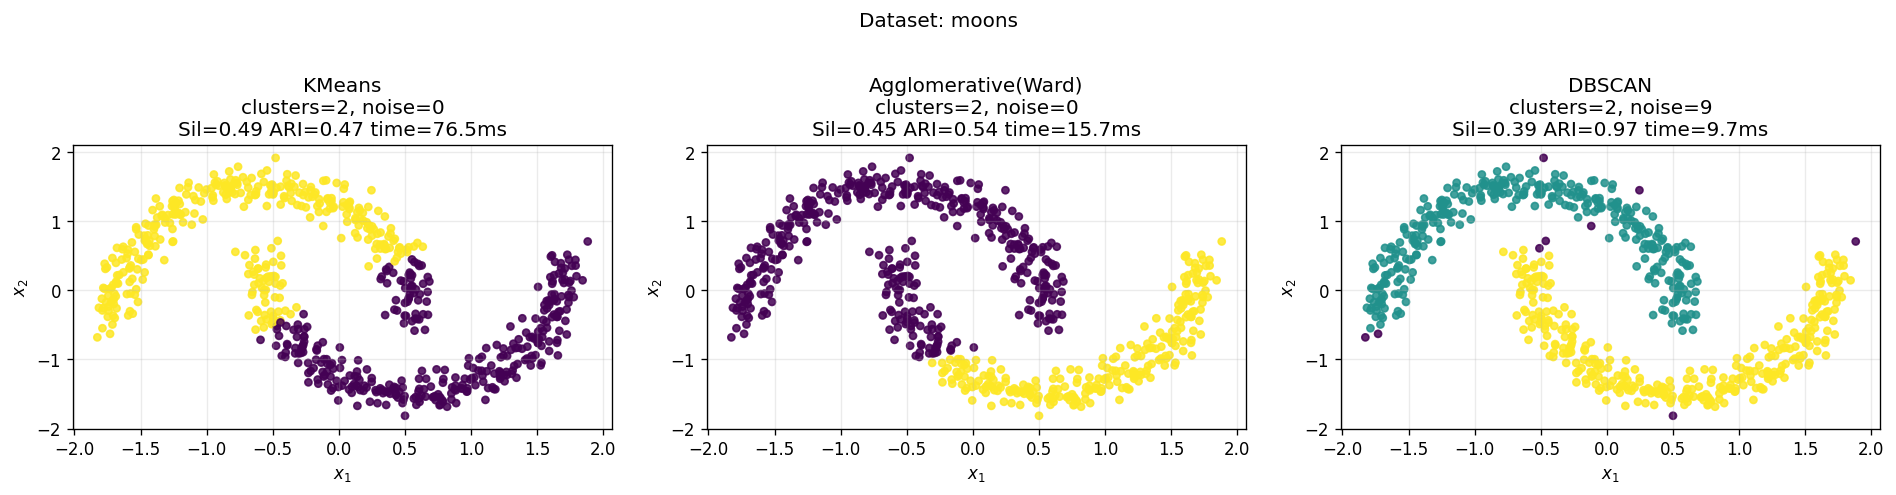

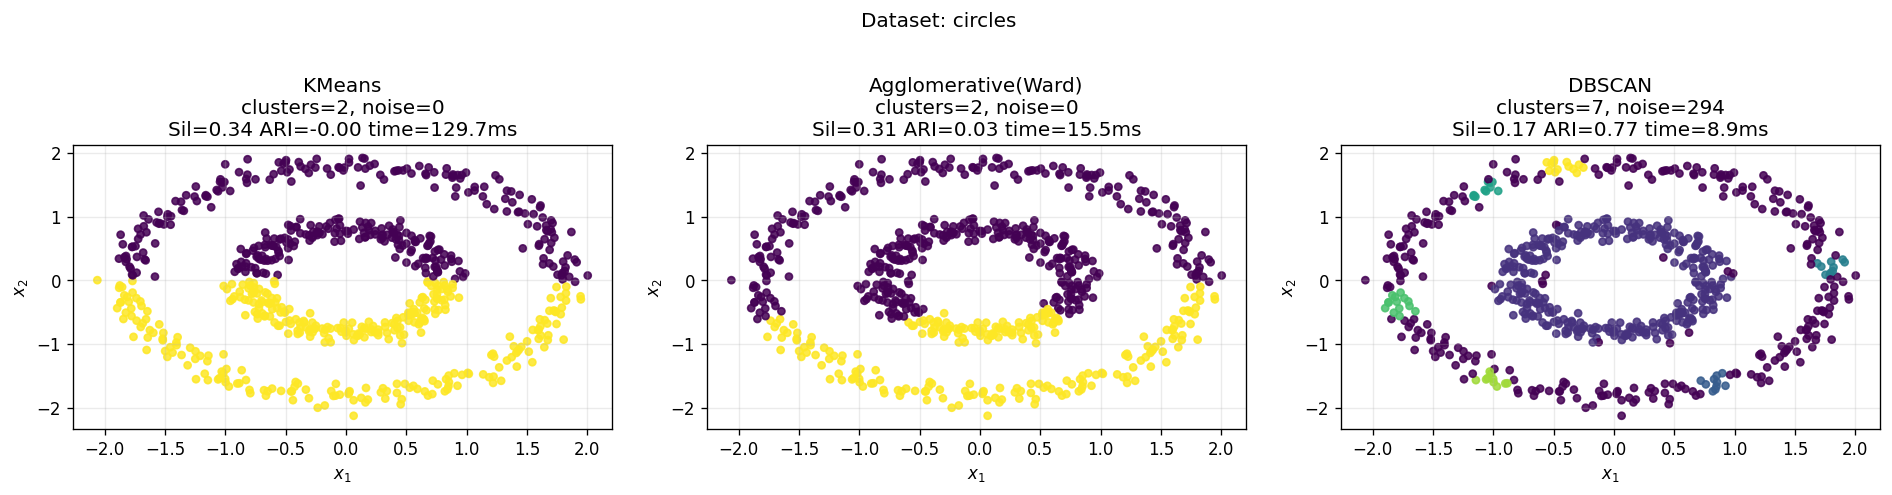

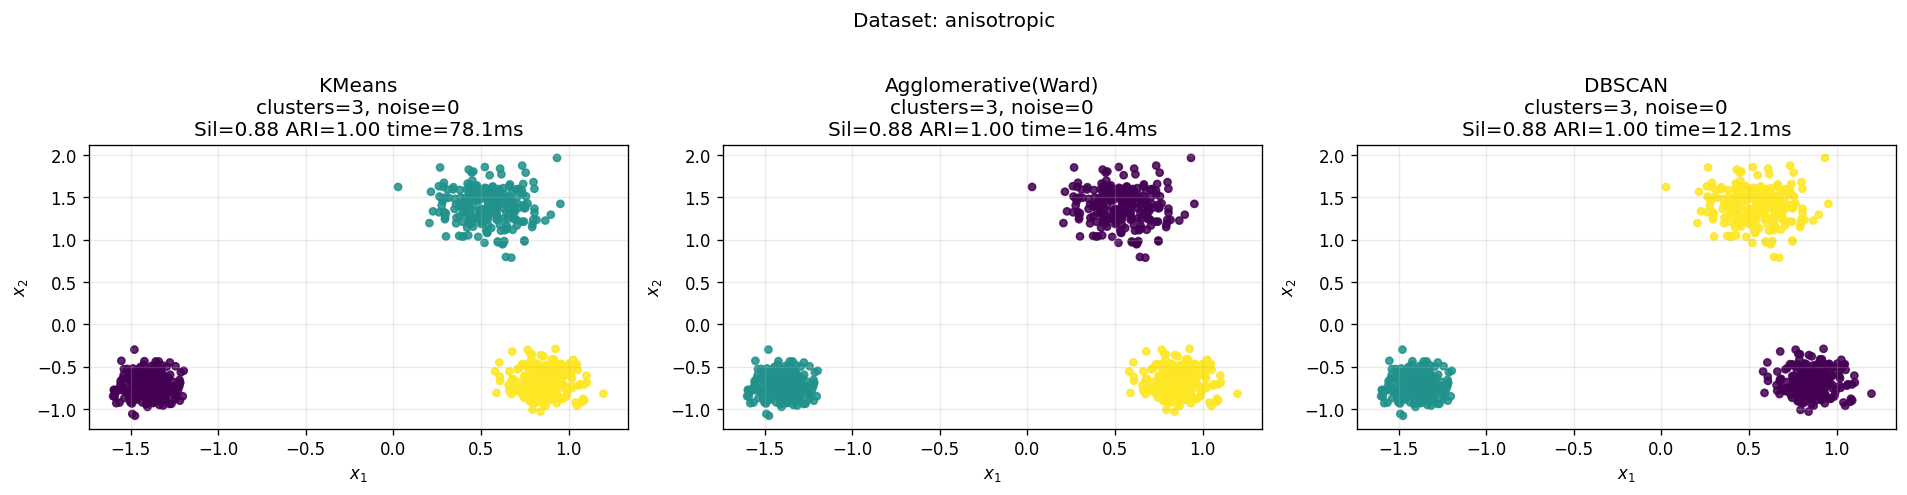

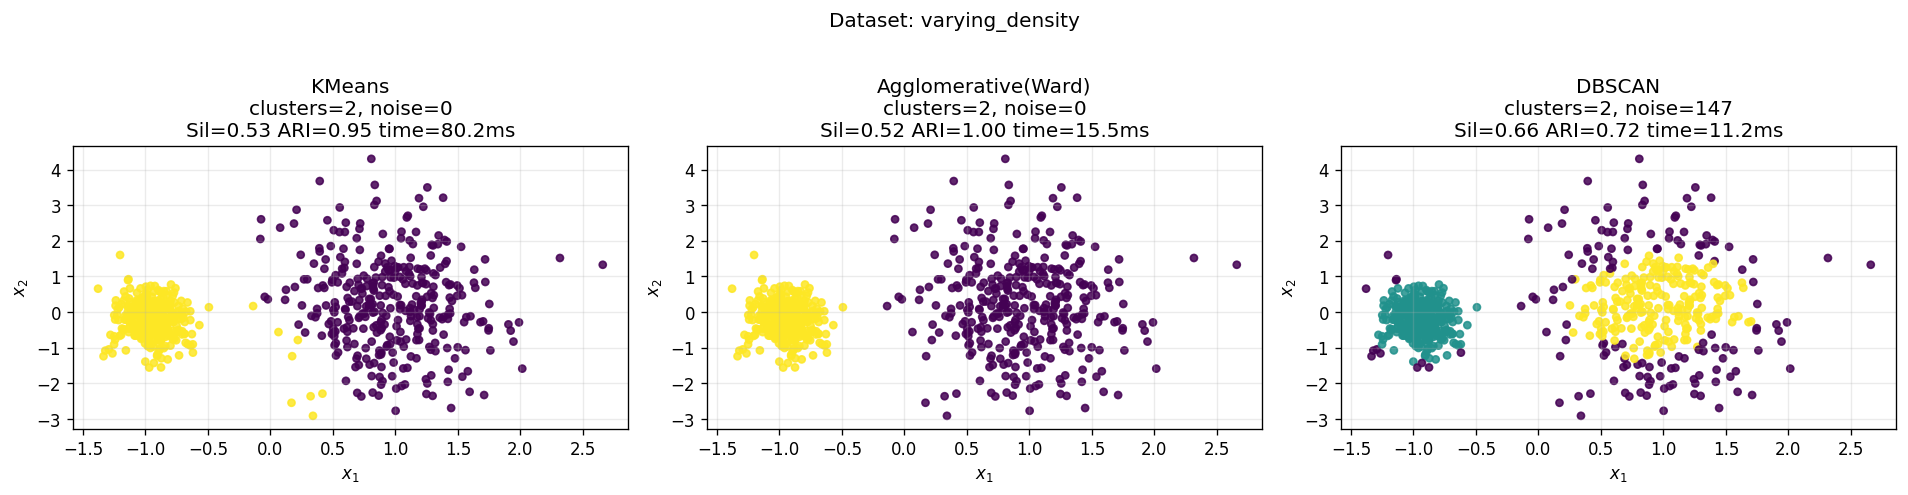

In [10]:
@dataclass
class AlgoResult:
    name: str
    labels: np.ndarray
    fit_time: float
    n_clusters: int
    n_noise: int
    sil: float
    ari: float

def evaluate_clustering(X, y_true=None, K=2, db_eps=0.2, db_min=8):
    results = []

    # K-means
    km = KMeans(n_clusters=K, init="k-means++", n_init=10, random_state=0)
    labels, t = timer(km.fit_predict, X)
    n_clusters = len(np.unique(labels))
    sil = silhouette_score(X, labels) if n_clusters > 1 else np.nan
    ari = adjusted_rand_score(y_true, labels) if y_true is not None else np.nan
    results.append(AlgoResult("KMeans", labels, t, n_clusters, 0, sil, ari))

    # Agglomerative (Ward)
    ag = AgglomerativeClustering(n_clusters=K, linkage="ward")
    labels, t = timer(ag.fit_predict, X)
    n_clusters = len(np.unique(labels))
    sil = silhouette_score(X, labels) if n_clusters > 1 else np.nan
    ari = adjusted_rand_score(y_true, labels) if y_true is not None else np.nan
    results.append(AlgoResult("Agglomerative(Ward)", labels, t, n_clusters, 0, sil, ari))

    # DBSCAN
    db = DBSCAN(eps=db_eps, min_samples=db_min)
    labels, t = timer(db.fit_predict, X)
    unique = set(labels)
    n_clusters = len(unique) - (1 if -1 in unique else 0)
    n_noise = int(np.sum(labels == -1))
    sil = silhouette_score(X[labels != -1], labels[labels != -1]) if n_clusters > 1 and np.sum(labels != -1) > 10 else np.nan
    ari = adjusted_rand_score(y_true, labels) if y_true is not None else np.nan
    results.append(AlgoResult("DBSCAN", labels, t, n_clusters, n_noise, sil, ari))

    return results

def show_results_grid(datasets, params):
    # params: dict[name] -> dict(K=..., db_eps=..., db_min=...)
    for name, (X, y_true) in datasets.items():
        p = params.get(name, {})
        K = p.get("K", 2)
        db_eps = p.get("db_eps", 0.2)
        db_min = p.get("db_min", 8)

        results = evaluate_clustering(X, y_true=y_true, K=K, db_eps=db_eps, db_min=db_min)

        fig, axes = plt.subplots(1, len(results), figsize=(16, 4))
        for ax, r in zip(axes, results):
            title = f"{r.name}\nclusters={r.n_clusters}, noise={r.n_noise}\nSil={r.sil:.2f} ARI={r.ari:.2f} time={1e3*r.fit_time:.1f}ms"
            scatter_2d(X, r.labels, title=title, ax=ax)
        fig.suptitle(f"Dataset: {name}", y=1.02, fontsize=12)
        plt.tight_layout()
        plt.show()

params = {
    "blobs": {"K": 4, "db_eps": 0.25, "db_min": 10},
    "moons": {"K": 2, "db_eps": 0.18, "db_min": 8},
    "circles": {"K": 2, "db_eps": 0.15, "db_min": 10},
    "anisotropic": {"K": 3, "db_eps": 0.24, "db_min": 10},
    "varying_density": {"K": 2, "db_eps": 0.22, "db_min": 10},
}

show_results_grid(datasets, params)

## 8) PCA via SVD (and why we usually prefer SVD)

PCA finds directions (principal components) that **maximize variance** of the projected data.

If $X\in\mathbb{R}^{m\times n}$ is the **centered** data matrix, one classical route is:
- covariance: $C = \frac{1}{m}X^TX$ (size $n\times n$)
- eigenvectors of $C$ give principal directions

But in practice, when $n$ is large, we avoid forming $C$ explicitly.

Instead we compute SVD directly:
$$
X = U\Sigma V^T
$$

Then:
- columns of $V$ are principal directions  
- singular values $\Sigma$ relate to explained variance

We will visualize:
- explained variance ratio  
- 2D projection  
- reconstruction error as we increase number of components

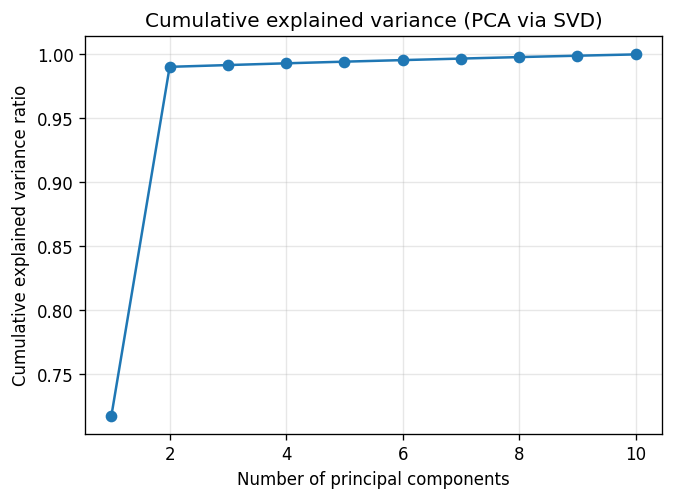

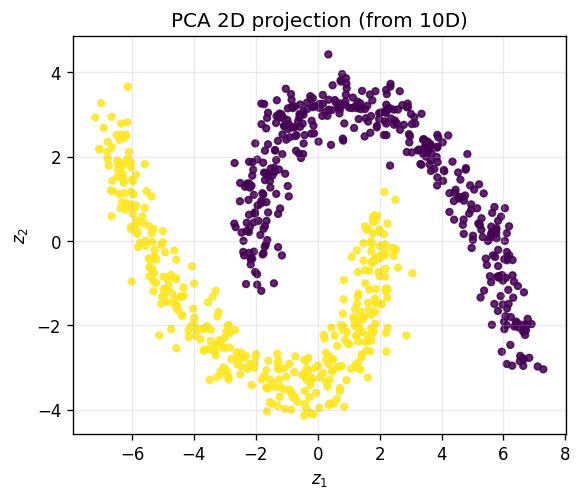

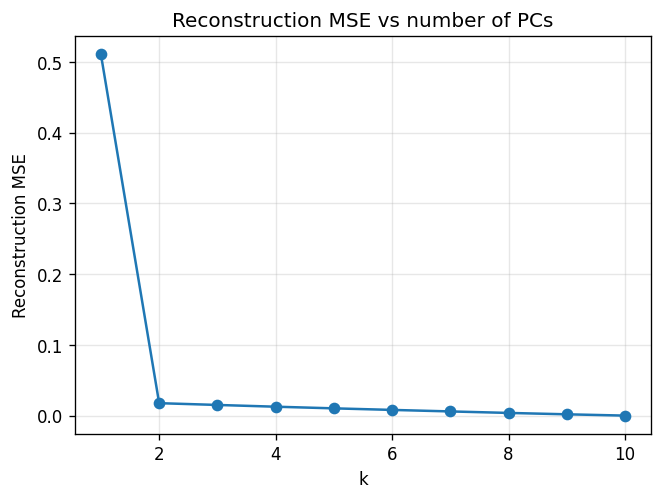

Reconstruction MSE with all 10 PCs (PCA): 0.0000


In [11]:
# Create a higher-dimensional dataset by embedding 2D structure into 10D with noise
rng = np.random.RandomState(0)
X2, y2 = make_moons(n_samples=800, noise=0.08, random_state=0)
X2 = standardize(X2)

# Embed into 10D: linear mix + extra noisy dimensions
W = rng.randn(2, 10)
X10 = X2 @ W + 0.15 * rng.randn(len(X2), 10)
X10 = X10 - X10.mean(axis=0, keepdims=True)  # center

pca = PCA(n_components=10, svd_solver="full", random_state=0)
Z = pca.fit_transform(X10)

fig, ax = plt.subplots(figsize=(6.2, 4.3))
ax.plot(np.arange(1, 11), np.cumsum(pca.explained_variance_ratio_), marker="o")
ax.set_title("Cumulative explained variance (PCA via SVD)")
ax.set_xlabel("Number of principal components")
ax.set_ylabel("Cumulative explained variance ratio")
ax.grid(True, alpha=0.3)
plt.show()

# 2D projection
fig, ax = plt.subplots(figsize=(5.3, 4.3))
ax.scatter(Z[:, 0], Z[:, 1], c=y2, s=16, alpha=0.85)
ax.set_title("PCA 2D projection (from 10D)")
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$")
ax.grid(True, alpha=0.25)
plt.show()

# Reconstruction error vs k
errs = []
ks = range(1, 11)
for k in ks:
    p = PCA(n_components=k, random_state=0)
    Zk = p.fit_transform(X10)
    Xhat = p.inverse_transform(Zk)
    errs.append(np.mean((X10 - Xhat) ** 2))

fig, ax = plt.subplots(figsize=(6.2, 4.3))
ax.plot(list(ks), errs, marker="o")
ax.set_title("Reconstruction MSE vs number of PCs")
ax.set_xlabel("k")
ax.set_ylabel("Reconstruction MSE")
ax.grid(True, alpha=0.3)
plt.show()


mse_pca_te = np.mean((X10 - p.inverse_transform(p.transform(X10))) ** 2)
print(f"Reconstruction MSE with all 10 PCs (PCA): {mse_pca_te:.4f}")



## 9) Autoencoders

Autoencoders learn a mapping:
- encoder: $x \mapsto z$  
- decoder: $z \mapsto \hat{x}$  

by minimizing reconstruction loss:
$$
\min_\theta \;\frac{1}{m}\sum_{i=1}^m \|x^{(i)} - \hat{x}^{(i)}\|^2
$$

### Key bridge to classical ML

If we use:
- **one hidden layer**
- **linear activations**
- **MSE loss**

then the autoencoder learns the same principal subspace as **PCA** (PCA is a special case of a neural network).

We'll show:
1) a **linear** autoencoder (implemented as PCA)  
2) a **nonlinear** autoencoder-like model using an MLP regressor (sklearn)  
3) **Linear autoencoder (GD)** — should match PCA’s subspace *up to rotation*  
4) anomaly detection: points with high reconstruction error

PCA (k=2)                    test MSE=0.0000
Linear AE (GD, k=2)          test MSE=0.0177
Nonlinear AE-like (MLP, k=2) test MSE=0.0355


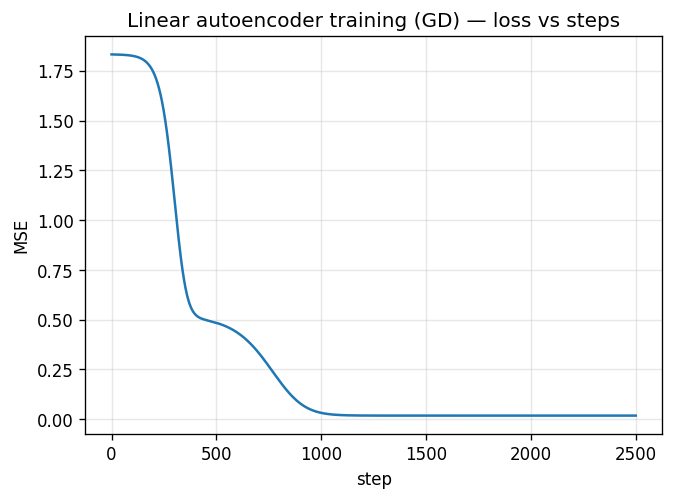

In [12]:
# Linear autoencoder (from scratch, gradient descent) + nonlinear bottleneck (MLPRegressor)

def train_linear_autoencoder_gd(X, k, lr=0.05, steps=2500, seed=0, weight_decay=0.0):
    rng = np.random.RandomState(seed)
    m, n = X.shape
    We = 0.01 * rng.randn(n, k)
    be = np.zeros((1, k))
    Wd = 0.01 * rng.randn(k, n)
    bd = np.zeros((1, n))

    losses = []
    for t in range(steps):
        Z = X @ We + be
        Xhat = Z @ Wd + bd
        E = (Xhat - X)
        loss = np.mean(E**2) + weight_decay*(np.mean(We**2)+np.mean(Wd**2))
        losses.append(loss)

        dXhat = (2.0/m) * E
        dWd = Z.T @ dXhat + 2*weight_decay*Wd/(k*n)
        dbd = np.sum(dXhat, axis=0, keepdims=True)

        dZ = dXhat @ Wd.T
        dWe = X.T @ dZ + 2*weight_decay*We/(n*k)
        dbe = np.sum(dZ, axis=0, keepdims=True)

        We -= lr * dWe
        be -= lr * dbe
        Wd -= lr * dWd
        bd -= lr * dbd

    return (We, be, Wd, bd, np.array(losses))

def linear_ae_predict(X, params):
    We, be, Wd, bd = params
    Z = X @ We + be
    Xhat = Z @ Wd + bd
    return Z, Xhat


# set data
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X10, test_size=0.25, random_state=0)
k_latent = 2
from sklearn.neural_network import MLPRegressor

params = train_linear_autoencoder_gd(X_train, k=k_latent, lr=0.0005, steps=2500, seed=0)
We, be, Wd, bd, losses_lin = params
_, Xhat_lin_te = linear_ae_predict(X_test, (We, be, Wd, bd))
mse_lin_te = float(np.mean((X_test - Xhat_lin_te)**2))

mlp = MLPRegressor(
    hidden_layer_sizes=(k_latent,),
    activation="tanh",
    solver="adam",
    max_iter=2500,
    random_state=0,
    early_stopping=True,
    n_iter_no_change=25,
    validation_fraction=0.2
)
mlp.fit(X_train, X_train)
Xhat_mlp_te = mlp.predict(X_test)
mse_mlp_te = float(np.mean((X_test - Xhat_mlp_te)**2))

print(f"PCA (k={k_latent})                    test MSE={mse_pca_te:.4f}")
print(f"Linear AE (GD, k={k_latent})          test MSE={mse_lin_te:.4f}")
print(f"Nonlinear AE-like (MLP, k={k_latent}) test MSE={mse_mlp_te:.4f}")

fig, ax = plt.subplots(figsize=(6.2, 4.3))
ax.plot(losses_lin)
ax.set_title("Linear autoencoder training (GD) — loss vs steps")
ax.set_xlabel("step")
ax.set_ylabel("MSE")
ax.grid(True, alpha=0.3)
plt.show()

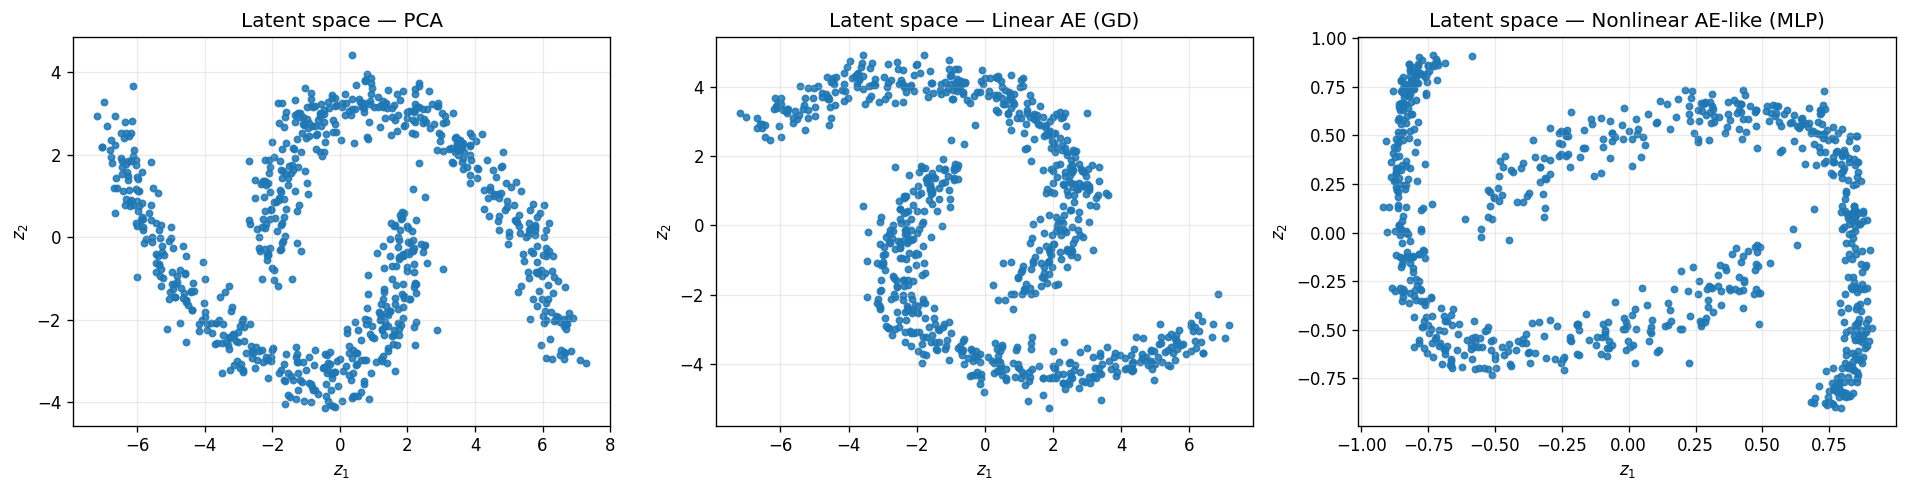

In [13]:
# Latent space visualization: PCA vs linear AE vs nonlinear bottleneck

def mlp_hidden_activations(mlp: MLPRegressor, X):
    W1, b1 = mlp.coefs_[0], mlp.intercepts_[0]
    return np.tanh(X @ W1 + b1)

Z_pca = pca.transform(X10)
Z_lin, _ = linear_ae_predict(X10, (We, be, Wd, bd))
Z_mlp = mlp_hidden_activations(mlp, X10)

fig, axes = plt.subplots(1, 3, figsize=(16, 4.2))

axes[0].scatter(Z_pca[:, 0], Z_pca[:, 1], s=14, alpha=0.85)
axes[0].set_title("Latent space — PCA")
axes[0].set_xlabel("$z_1$"); axes[0].set_ylabel("$z_2$")
axes[0].grid(True, alpha=0.25)

axes[1].scatter(Z_lin[:, 0], Z_lin[:, 1], s=14, alpha=0.85)
axes[1].set_title("Latent space — Linear AE (GD)")
axes[1].set_xlabel("$z_1$"); axes[1].set_ylabel("$z_2$")
axes[1].grid(True, alpha=0.25)

axes[2].scatter(Z_mlp[:, 0], Z_mlp[:, 1], s=14, alpha=0.85)
axes[2].set_title("Latent space — Nonlinear AE-like (MLP)")
axes[2].set_xlabel("$z_1$"); axes[2].set_ylabel("$z_2$")
axes[2].grid(True, alpha=0.25)

plt.tight_layout()
plt.show()

## Autoencoder for Anomaly Detection (Engineering Perspective)

Industrial scenario:

We assume that we only have access to **normal operating data**.
Faults are rare and often unseen during training.

Core idea:

1. Train a model to reconstruct *normal behavior*
2. Compute reconstruction error:

$$
E(x) = \|x - \hat{x}\|^2
$$

3. Large error → unusual → potential anomaly

---

### Important Concept

The model does **not** learn anomalies.
It learns what is *normal*.

If a point lies outside the learned manifold,
the reconstruction error increases.

---

### In this demo:

- 1200 normal samples (10D Gaussian)
- 80 anomalies (shifted in one direction)
- Train only on normal data

We compare:

- Linear Autoencoder (PCA)
- Nonlinear Autoencoder (MLP)

Question:

Which model separates normal and anomaly errors better?

PCA  thr@95% normal = 0.8260  | TP=23 TN=1140 FP=60 FN=57
MLP  thr@95% normal = 0.8464  | TP=32 TN=1140 FP=60 FN=48


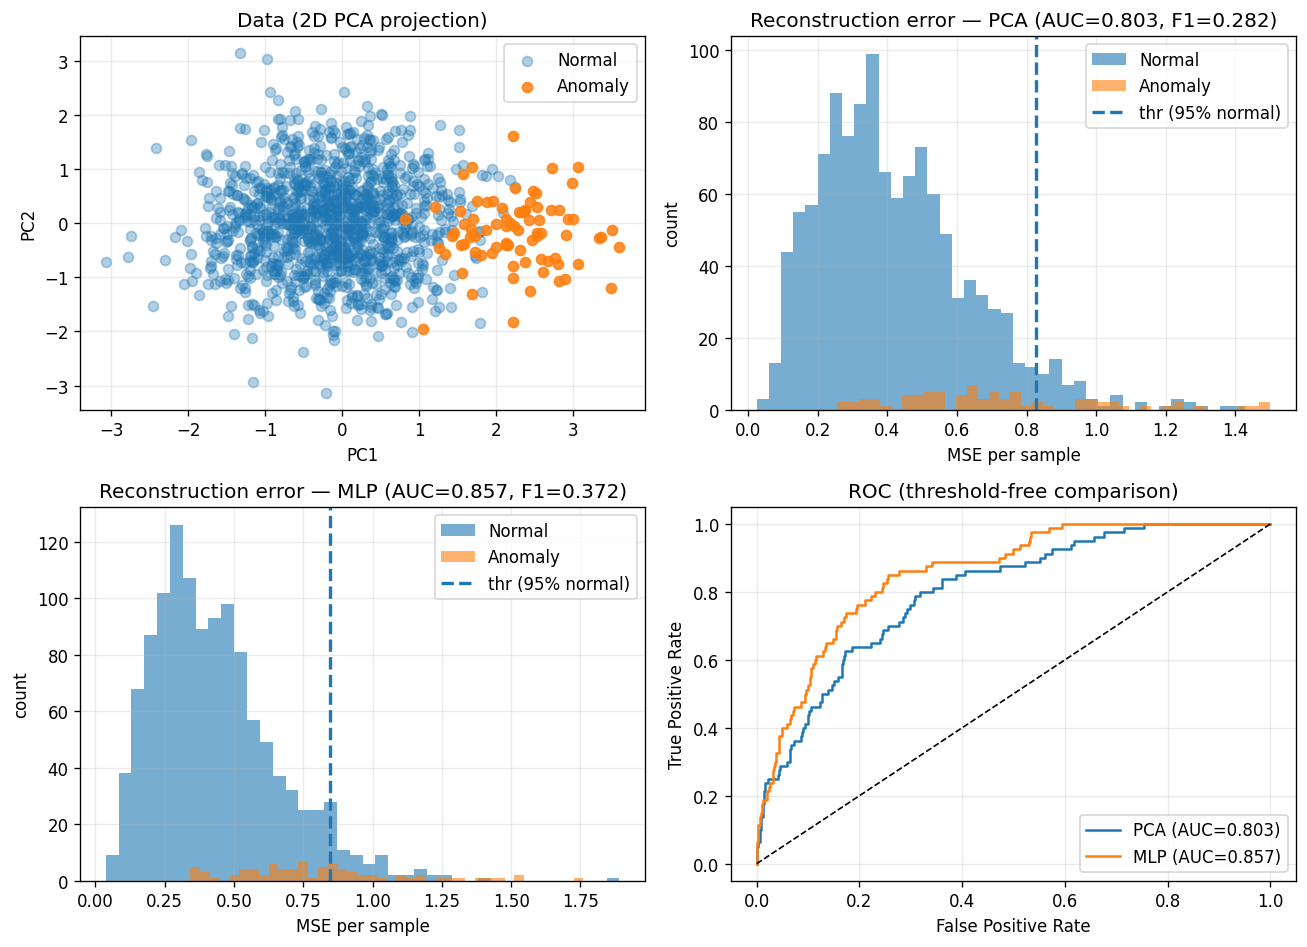

----- Summary -----
PCA: AUC=0.803, F1@95%thr=0.282
MLP: AUC=0.857, F1@95%thr=0.372
Winner by AUC: MLP


In [14]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import roc_curve, auc, f1_score

# -------------------------------------------------------
# Utilities
# -------------------------------------------------------
def mse_per_sample(X, Xhat):
    return np.mean((X - Xhat) ** 2, axis=1)

def threshold_at_quantile(err, y_anom, q=95):
    """Threshold defined from NORMAL samples only."""
    thr = np.percentile(err[y_anom == 0], q)
    pred = (err > thr).astype(int)
    return thr, pred

def confusion(y_true, y_pred):
    tp = int(np.sum((y_true == 1) & (y_pred == 1)))
    tn = int(np.sum((y_true == 0) & (y_pred == 0)))
    fp = int(np.sum((y_true == 0) & (y_pred == 1)))
    fn = int(np.sum((y_true == 1) & (y_pred == 0)))
    return tp, tn, fp, fn

# -------------------------------------------------------
# 0) Data (10D): normal + shifted anomalies
# -------------------------------------------------------
rng = np.random.RandomState(1)

n_normal, n_anom, d = 1200, 80, 10
shift = np.array([2.5] + [0] * (d - 1))

X_normal = rng.randn(n_normal, d) * 0.8
X_anom   = rng.randn(n_anom,   d) * 0.6 + shift

X_all  = np.vstack([X_normal, X_anom])
y_anom = np.hstack([np.zeros(n_normal, dtype=int), np.ones(n_anom, dtype=int)])

# Center using training (normal) mean only (avoids leakage)
mu = X_normal.mean(axis=0, keepdims=True)
X_train = X_normal - mu
X_eval  = X_all - mu

# -------------------------------------------------------
# 1) Models: linear AE (PCA) vs nonlinear AE-like (MLP)
# -------------------------------------------------------
k_latent = 3

# --- PCA (linear AE) ---
pca = PCA(n_components=k_latent, random_state=0)
pca.fit(X_train)
Xhat_pca = pca.inverse_transform(pca.transform(X_eval))
err_pca = mse_per_sample(X_eval, Xhat_pca)

# --- MLP autoencoder-like (nonlinear) ---
mlp = MLPRegressor(
    hidden_layer_sizes=(k_latent,),
    activation="tanh",
    solver="adam",
    max_iter=2500,
    random_state=0,
    early_stopping=True,
    n_iter_no_change=30,
    validation_fraction=0.2,
)
mlp.fit(X_train, X_train)
Xhat_mlp = mlp.predict(X_eval)
err_mlp = mse_per_sample(X_eval, Xhat_mlp)

# -------------------------------------------------------
# 2) Thresholding demo (95th percentile of NORMAL errors)
# -------------------------------------------------------
thr_pca, pred_pca = threshold_at_quantile(err_pca, y_anom, q=95)
thr_mlp, pred_mlp = threshold_at_quantile(err_mlp, y_anom, q=95)

tp, tn, fp, fn = confusion(y_anom, pred_pca)
print(f"PCA  thr@95% normal = {thr_pca:.4f}  | TP={tp} TN={tn} FP={fp} FN={fn}")

tp, tn, fp, fn = confusion(y_anom, pred_mlp)
print(f"MLP  thr@95% normal = {thr_mlp:.4f}  | TP={tp} TN={tn} FP={fp} FN={fn}")

# -------------------------------------------------------
# 3) ROC/AUC (threshold-free comparison)
# -------------------------------------------------------
fpr_pca, tpr_pca, _ = roc_curve(y_anom, err_pca)
fpr_mlp, tpr_mlp, _ = roc_curve(y_anom, err_mlp)
auc_pca = auc(fpr_pca, tpr_pca)
auc_mlp = auc(fpr_mlp, tpr_mlp)

f1_pca = f1_score(y_anom, pred_pca)
f1_mlp = f1_score(y_anom, pred_mlp)

# -------------------------------------------------------
# 4) Visualization in ONE figure (subplots)
#    - Data geometry (2D PCA projection for visualization only)
#    - Error histograms with threshold line
#    - ROC curve
# -------------------------------------------------------
X_vis = PCA(n_components=2, random_state=0).fit_transform(X_eval)

fig, axes = plt.subplots(2, 2, figsize=(11, 8))

# (a) Data geometry
ax = axes[0, 0]
ax.scatter(X_vis[y_anom == 0, 0], X_vis[y_anom == 0, 1], alpha=0.35, label="Normal")
ax.scatter(X_vis[y_anom == 1, 0], X_vis[y_anom == 1, 1], alpha=0.85, label="Anomaly")
ax.set_title("Data (2D PCA projection)")
ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
ax.grid(True, alpha=0.25)
ax.legend()

# (b) Error histogram: PCA
ax = axes[0, 1]
ax.hist(err_pca[y_anom == 0], bins=40, alpha=0.6, label="Normal")
ax.hist(err_pca[y_anom == 1], bins=40, alpha=0.6, label="Anomaly")
ax.axvline(thr_pca, linestyle="--", linewidth=2, label="thr (95% normal)")
ax.set_title(f"Reconstruction error — PCA (AUC={auc_pca:.3f}, F1={f1_pca:.3f})")
ax.set_xlabel("MSE per sample"); ax.set_ylabel("count")
ax.grid(True, alpha=0.25)
ax.legend()

# (c) Error histogram: MLP
ax = axes[1, 0]
ax.hist(err_mlp[y_anom == 0], bins=40, alpha=0.6, label="Normal")
ax.hist(err_mlp[y_anom == 1], bins=40, alpha=0.6, label="Anomaly")
ax.axvline(thr_mlp, linestyle="--", linewidth=2, label="thr (95% normal)")
ax.set_title(f"Reconstruction error — MLP (AUC={auc_mlp:.3f}, F1={f1_mlp:.3f})")
ax.set_xlabel("MSE per sample"); ax.set_ylabel("count")
ax.grid(True, alpha=0.25)
ax.legend()

# (d) ROC
ax = axes[1, 1]
ax.plot(fpr_pca, tpr_pca, label=f"PCA (AUC={auc_pca:.3f})")
ax.plot(fpr_mlp, tpr_mlp, label=f"MLP (AUC={auc_mlp:.3f})")
ax.plot([0, 1], [0, 1], "k--", linewidth=1)
ax.set_title("ROC (threshold-free comparison)")
ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
ax.grid(True, alpha=0.25)
ax.legend()

plt.tight_layout()
plt.show()

print("----- Summary -----")
print(f"PCA: AUC={auc_pca:.3f}, F1@95%thr={f1_pca:.3f}")
print(f"MLP: AUC={auc_mlp:.3f}, F1@95%thr={f1_mlp:.3f}")
print("Winner by AUC:", "PCA" if auc_pca > auc_mlp else "MLP")

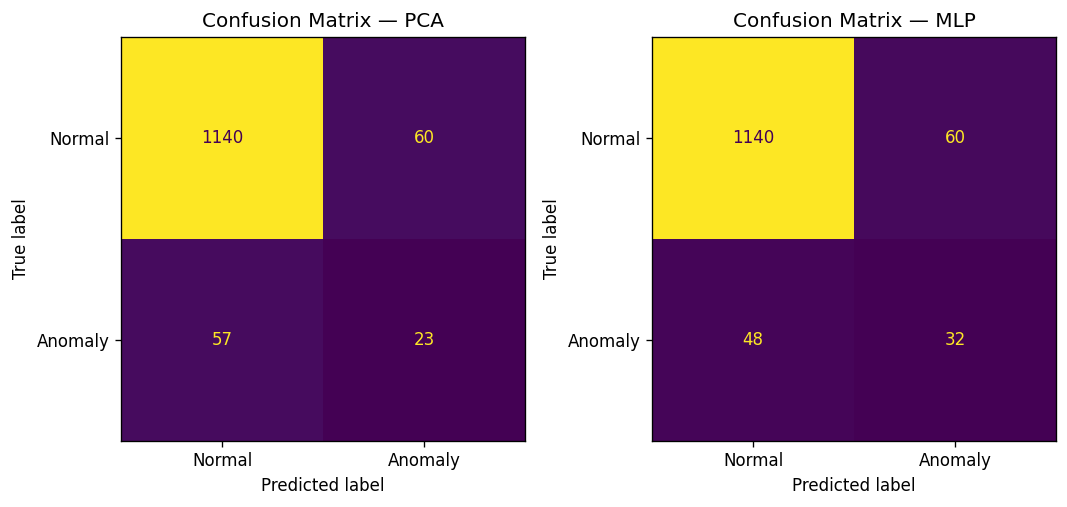

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# -------------------------------------------------------
# Confusion matrices (at 95% threshold)
# -------------------------------------------------------
cm_pca = confusion_matrix(y_anom, pred_pca)
cm_mlp = confusion_matrix(y_anom, pred_mlp)

fig, axes = plt.subplots(1, 2, figsize=(9, 4.5))

disp1 = ConfusionMatrixDisplay(cm_pca, display_labels=["Normal", "Anomaly"])
disp1.plot(ax=axes[0], colorbar=False)
axes[0].set_title("Confusion Matrix — PCA")

disp2 = ConfusionMatrixDisplay(cm_mlp, display_labels=["Normal", "Anomaly"])
disp2.plot(ax=axes[1], colorbar=False)
axes[1].set_title("Confusion Matrix — MLP")

plt.tight_layout()
plt.show()

## 10) Takeaways (what students should remember)

### Clustering
- **K-means**: fast, simple, but assumes spherical clusters and needs $K$  
- **Hierarchical**: interpretable via dendrogram; linkage matters; not ideal for very large datasets  
- **DBSCAN**: can find arbitrary shapes + outliers, but sensitive to $\varepsilon$ and density variations

### Dimensionality reduction / representation
- **PCA**: linear low-dimensional structure; computed efficiently via **SVD**  
- **Autoencoders**: learn representations (potentially nonlinear); useful for compression and anomaly detection  
- **Bridge**: *linear autoencoder = PCA*

### Engineering mindset
1. Plot the data first (geometry dictates method)  
2. Standardize features (distance and density depend on scale)  
3. Use metrics (silhouette) as diagnostics, not as truth  
4. Iterate: parameters and assumptions matter more than the algorithm name